# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [121]:
METRICS_PATH <- "./metrics/" 

In [122]:
# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# install.packages(c('reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'zoo'))

Then, the dependencies

In [123]:
# To call python from R
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(zoo) # moving averages        

Load the the Python `integration.py` script to use its variable in R

In [124]:
#use_virtualenv('.venv/', required = TRUE)
# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python("definitions.py"))

Load the graph network as an adjancency matrix

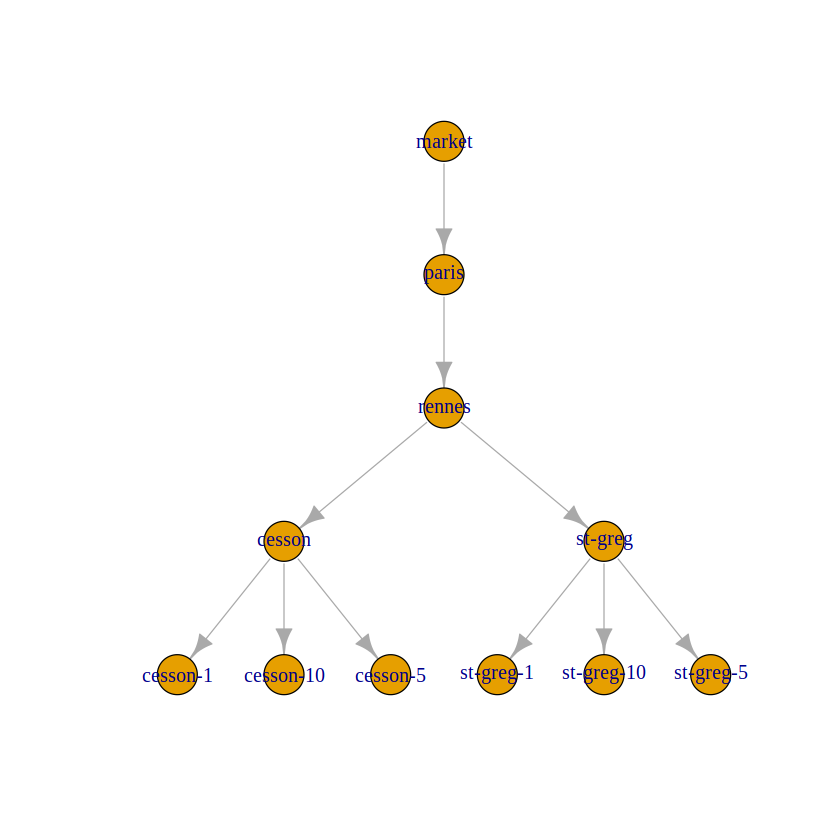

In [125]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret <- matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }
  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)
net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
plot(net, layout = layout_as_tree)

# ceb <- cluster_edge_betweenness(g)
#
# dendPlot(ceb, mode="hclust")
# plot(ceb, g)

## Data preprocessing

In [126]:
names_raw <- read.csv2(file = paste(METRICS_PATH, "names.csv", sep = "/"), header = TRUE, sep = "\t")
names <- hashmap()
names[names_raw$instance] <- names_raw$name

missing <- data.frame(instance = names_raw$name, n = 0)

Load the names of the node and their correspondance in their IP on the virtual network

In [127]:
prepare <- function(x) {
  return(
    x %>%
      mutate(instance = names[instance]) %>%
      mutate(instance = as.character(instance)) %>%
      mutate(timestamp_raw = as.numeric(as.character(timestamp))) %>%
      mutate(timestamp = as.POSIXct(timestamp_raw, origin = "1970-01-01")) %>%
      mutate(value = as.numeric(as.character(value))) %>%
      merge(missing, all = TRUE) %>%
      arrange(instance)
  )
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [128]:
mem <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  distinct(instance, value, .keep_all = TRUE) %>%
  select(c(instance, value)) %>%
  mutate(dyn = formattable::percent(value / max(value, na.rm = TRUE))) %>%
  mutate(value = as.numeric(as.character(value)))

cpu <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_used.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  select(c(instance, value)) %>%
  distinct(instance, value, .keep_all = TRUE) %>%
  group_by(instance) %>%
  mutate(value = as.numeric(as.character(value)))

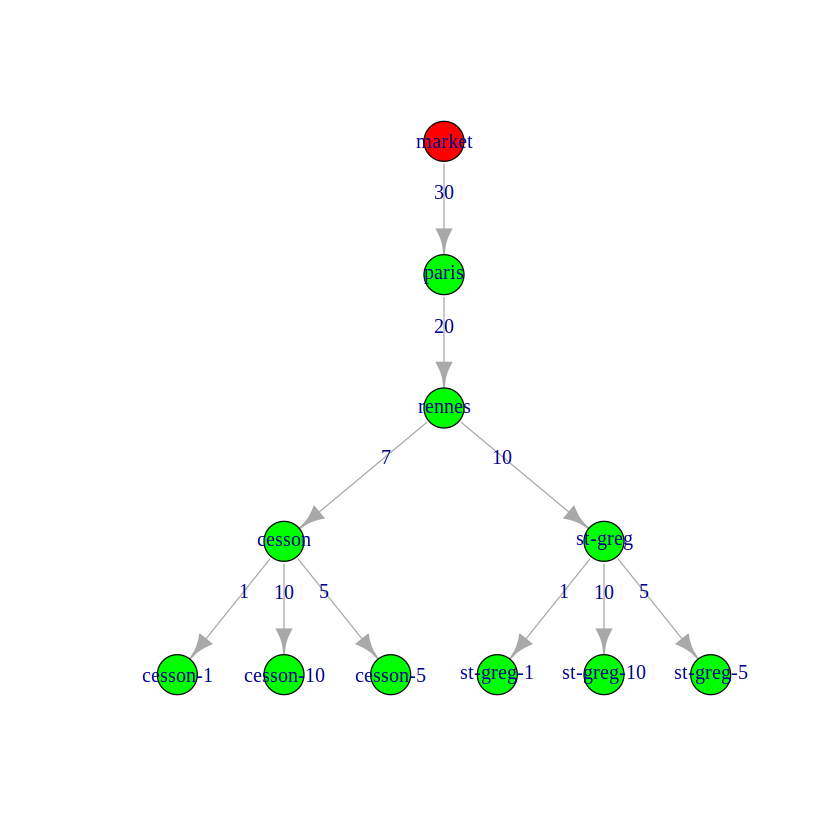

In [129]:
PercentageColourConnected <- function(x) {
  colorRampPalette(c("red", "green"))(2)[ifelse(is.na(x), 1, 2)]
}
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_connected)$color <- PercentageColourConnected(mem$value)
plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)

instance,n
<chr>,<int>
cesson,3
cesson-1,2
paris,20
rennes,13
st-greg,4
st-greg-1,4
st-greg-10,2
st-greg-5,4


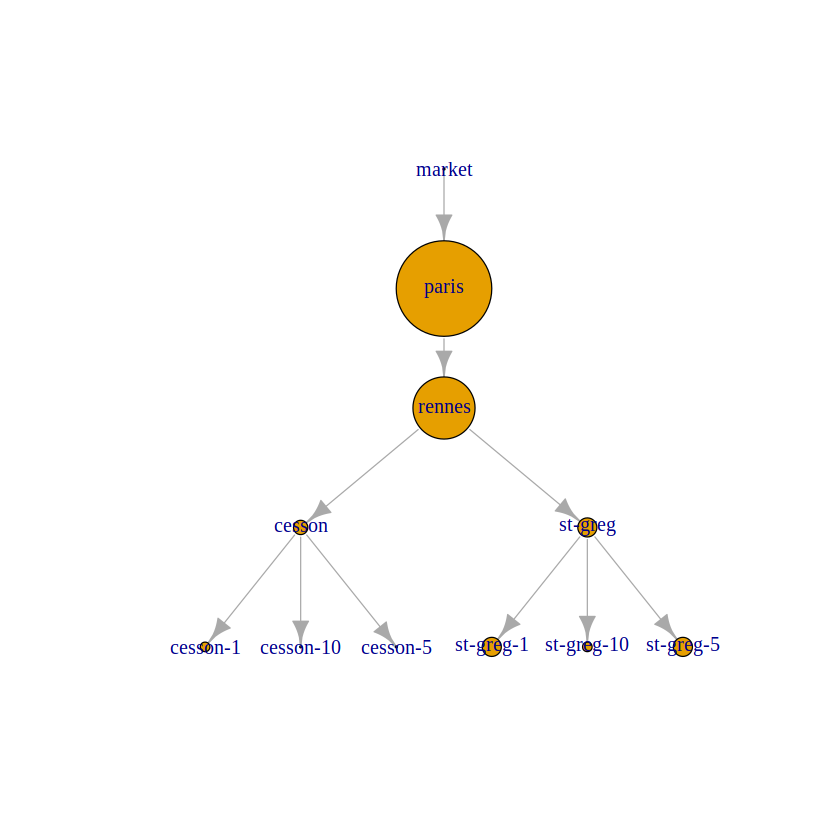

In [130]:
bids_raw <- read.csv2(file = paste(METRICS_PATH, "fog_node_bids.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value))

bids_won_all_zero <- data.frame(instance = names_raw$name, n = 0)
bids_won <- bids_won_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  group_by(instance) %>%
  summarise(n = n())

bids_won

# Add missing participants and put them at 0
bids_won <- bids_won %>%
  merge(bids_won_all_zero, all = TRUE) %>%
  group_by(instance) %>%
  summarise(across(everything(), sum)) %>%
  arrange()

net_won <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
V(net_won)$size <- bids_won$n * 2
plot(net_won, layout = layout_as_tree)

Plot the free cpu

Warning message in max(free, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 1 row containing missing values (`geom_step()`).”


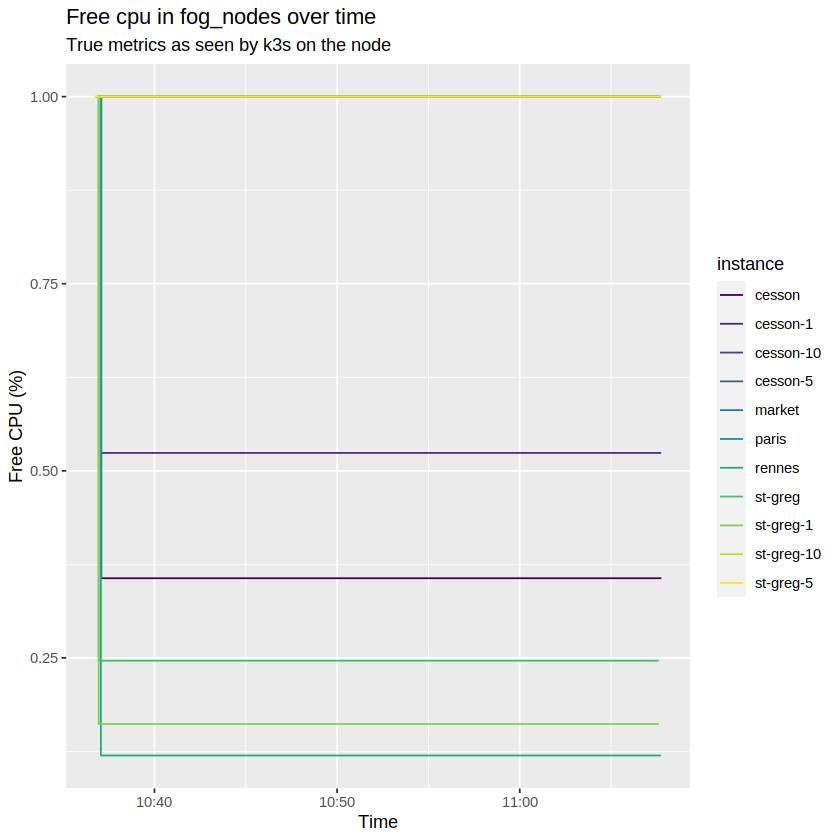

In [131]:
cpu_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
cpu_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_cpu_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

cpu_free <- cpu_used %>%
  inner_join(cpu_avail, by = c("instance", "timestamp")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

cpu_free %>%
ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
  labs(x = "Time", y = "Free CPU (%)", title = "Free cpu in fog_nodes over time", subtitle = "True metrics as seen by k3s on the node") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Plot the free memory

Warning message in max(free, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 1 row containing missing values (`geom_step()`).”


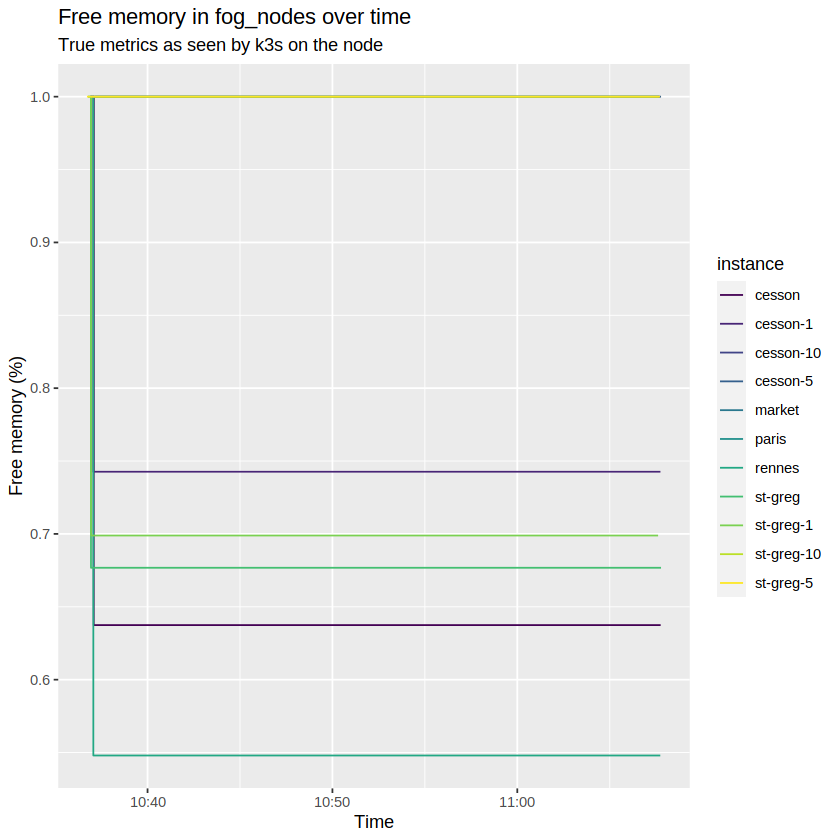

In [132]:
mem_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
mem_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
labs(x = "Time", y = "Free memory (%)", title = "Free memory in fog_nodes over time", subtitle = "True metrics as seen by k3s on the node") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Warning message in max(free, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Removed 1 row containing missing values (`geom_step()`).”


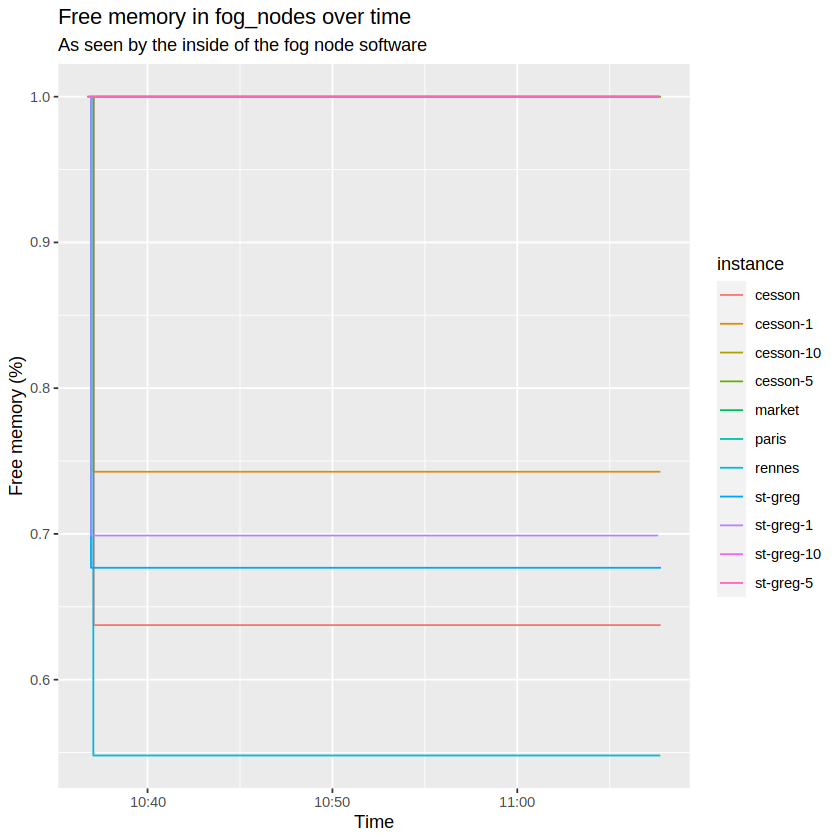

In [133]:
mem_used <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_used.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()
mem_avail <- read.csv2(file = paste(METRICS_PATH, "fog_node_memory_available.csv", sep = "/"), header = TRUE, sep = "\t") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent)

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  geom_step() +
  # geom_point() +
  labs(x = "Time", y = "Free memory (%)", title = "Free memory in fog_nodes over time", subtitle = "As seen by the inside of the fog node software")

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

In [134]:
latency <- read.csv2(file = paste(METRICS_PATH, "fog_node_neighbors_latency_rolling_avg.csv", sep = "/"), header = TRUE, sep = "\t") %>%
  prepare() %>%
  mutate(instance_to = as.character(names[instance_to]))

# latency %>%
#   group_by(instance, instance_to) %>%
#   summarize(mean_ms = round(median(value*1000), 0))

p <- c(.01, .1, 0.95, 0.99, 0.999, 1)
p_names <- map_chr(p, ~paste0(.x*100, ""))
p_funs <- map(p, ~partial(quantile, probs = .x, na.rm = TRUE)) %>% 
  set_names(nm = p_names)

quantiles <- latency %>%
    mutate(value = value*1000) %>%
    group_by(instance, instance_to) %>%
    summarize_at(vars(value), funs(!!!p_funs))
print(quantiles)

# quantiles <- within(quantiles, 
#                    latency <- factor(latency, 
#                                       levels=names(sort(table(as.numeric(latency)), 
#                                                         decreasing=TRUE))))
# quantiles <- within(quantiles, 
#                    quantile <- factor(quantile, 
#                                       levels=names(sort(table(as.numeric(quantile)), 
#                                                         decreasing=TRUE))))
# print(quantiles)

# print(
#   quantiles %>%
#     arrange(desc(as.numeric(latency))) %>%
#     ggplot(
#       aes(
#         x = latency,
#         y = value,
#         fill = quantile,
#       )
#     ) +
#     geom_col(position="dodge") +
#     scale_y_continuous(trans='sqrt') + 
#     labs(
#       x = "Ping latencies between hosts",
#       y = "Avg observed lat. (s) by quantiles",
#       title = "Latency between edge and the function.",
#       subtitle = paste("Color maches the quantile")
#     ) +
#     scale_color_viridis(discrete = TRUE, option = "D") +
#     scale_fill_viridis(discrete = TRUE)
# )


# latency %>%
#   ggplot(aes(x = timestamp, y = value, color = instance_to)) +
# geom_smooth() +
#   labs(x = "Time", y = "Latency (s)", title = "Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
#   scale_y_continuous(trans='sqrt') + 
#   facet_grid(rows = vars(instance))+
#   scale_color_viridis(discrete = TRUE, option = "D") +
  # scale_fill_viridis(discrete = TRUE) 

# latency %>%
#   ggplot(aes(x = timestamp, y = value, color = instance_to)) +
# geom_point() +
#   labs(x = "Time", y = "Latency (s)", title = "Evolution of perceived latency from a node to its neighbors over time", subtitle = "Each row is a “from”") +
#   scale_color_viridis(discrete = TRUE, option = "D") +
#   scale_fill_viridis(discrete = TRUE) 

# latency %>% group_by(instance, instance_to) %>% mutate(median = median(value)) %>%
#   ggplot(aes(x = instance, y = median, color = instance_to)) +
#   geom_point() +
#   # scale_y_continuous(trans='sqrt') + 
#   labs(x = "Source", y = "Latency (s)", title = "Max latency from a node to its neighbors") +
#   # facet_grid(rows = vars(instance_to))+
#   scale_color_viridis(discrete = TRUE, option = "D") +
#   scale_fill_viridis(discrete = TRUE) 

# A tibble: 20 × 8
# Groups:   instance [11]
   instance   instance_to   `1`  `10`  `95`  `99` `99.9` `100`
   <chr>      <chr>       <dbl> <dbl> <dbl> <dbl>  <dbl> <dbl>
 1 cesson     cesson-1     2.5    2.5  2.75  3       3     3  
 2 cesson     cesson-10   20.5   20.5 20.5  21.5    22    22  
 3 cesson     cesson-5    10.5   10.5 10.5  10.8    11    11  
 4 cesson     rennes      14.5   14.5 14.8  15.0    15.2  15.2
 5 cesson-1   cesson       2.5    2.5  2.5   2.5     2.5   2.5
 6 cesson-10  cesson      20.5   20.5 20.5  20.5    20.5  20.5
 7 cesson-5   cesson      10.5   10.5 10.5  11      11    11  
 8 market     paris       60.5   60.5 61    61      61    61  
 9 paris      market      60.5   60.5 61    61      61    61  
10 paris      rennes      40.5   40.5 41    41      41    41  
11 rennes     cesson      14.5   14.5 15    15      15    15  
12 rennes     paris       40.5   40.5 41    41      41    41  
13 rennes     st-greg     20.5   20.5 20.5  20.6    20.8  20.8
14 st-greg

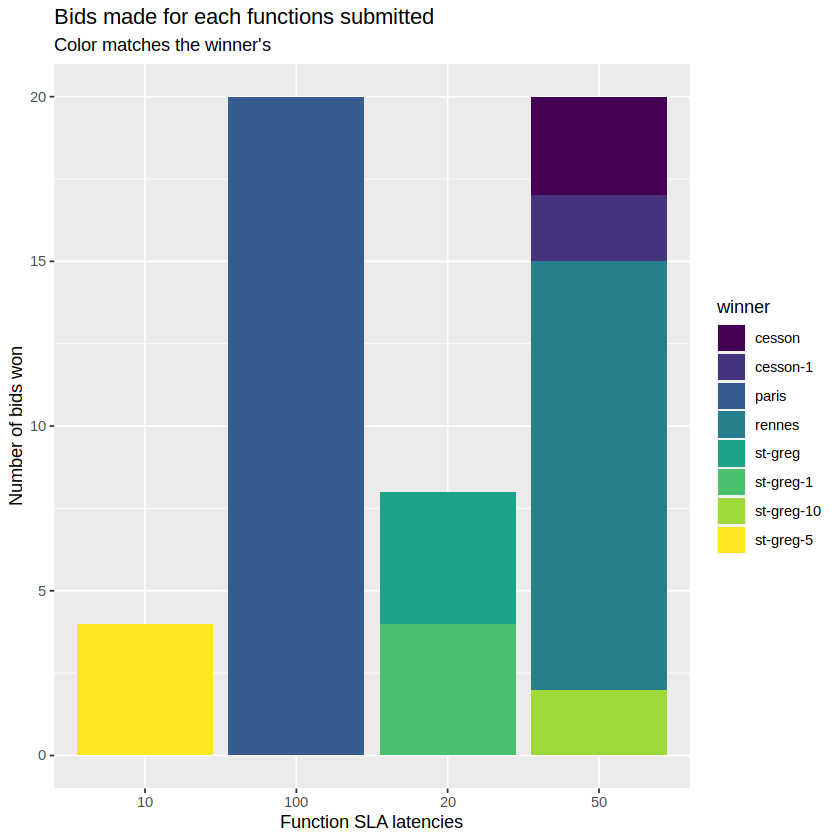

In [135]:
bids_won_function <- bids_raw %>%
  group_by(function_name) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

# head(bids_won_function)

bids_function <- bids_raw %>%
  mutate(winner = instance) %>%
  select(instance, function_name, value) %>%
  distinct() %>%
  mutate(latency = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[, 4]) %>%
  inner_join(bids_won_function, by = c("function_name"))

# head(bids_function)

bids_function %>%
    group_by(winner, latency, function_name) %>%
    arrange(desc(as.numeric(latency))) %>%   
    select(winner, latency, function_name) %>%
    distinct() %>%
    ggplot(
      aes(
        x = latency,
        fill = winner,
      )
    ) +
  geom_bar() +
  labs(x = "Function SLA latencies", y = "Number of bids won", title = "Bids made for each functions submitted", subtitle = "Color matches the winner's")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

winner,function_name,value
<chr>,<chr>,<dbl>
st-greg-5,echo--001--10--400--300,0.2006276
st-greg-5,echo--002--10--400--300,0.2566854
st-greg-5,echo--003--10--400--300,0.3624381
st-greg-5,echo--004--10--400--300,0.6521492
st-greg,echo--020--20--400--300,0.1651789
st-greg-1,echo--021--20--400--300,0.1746128


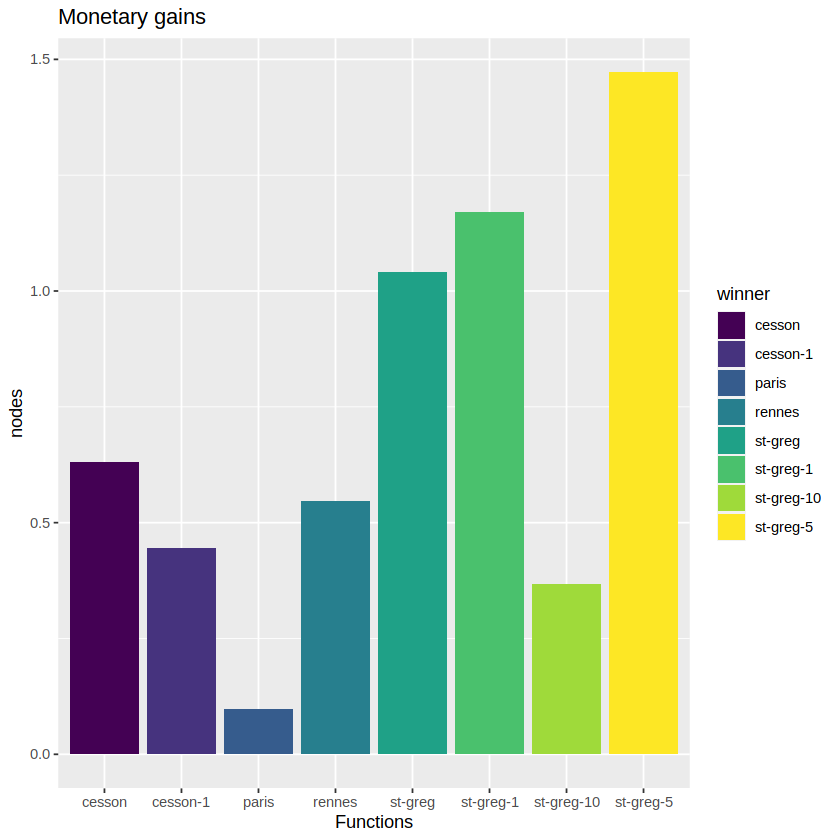

In [136]:
winner_gains <- bids_won_function %>%
  select(c(winner, function_name, value)) %>%
  distinct()
head(winner_gains)

winner_gains %>%
  ggplot(aes(x = winner, y = value, fill = winner)) +
  geom_col() +
  labs(x = "Functions", y = "nodes", title = "Monetary gains")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

latency,period,quantile,value
<fct>,<int>,<fct>,<dbl>
10,10,95,0.004715577
10,10,99,0.005300245
10,10,99.9,0.005545988
10,10,100,0.005570588
10,50,95,0.001414286
10,50,99,0.001525278


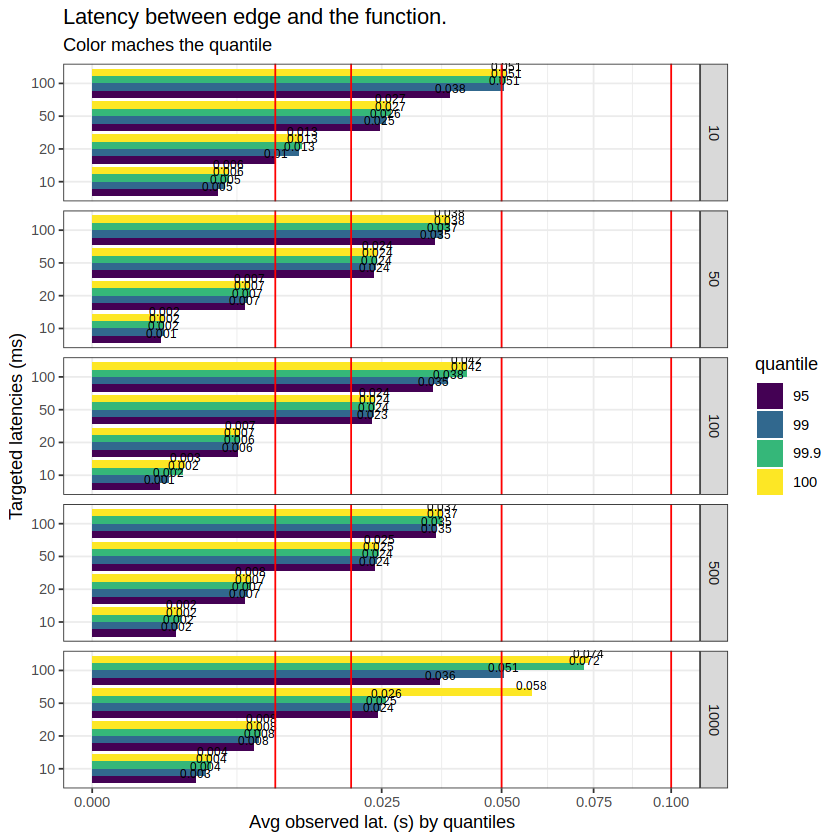

In [199]:
echo_sum <-
  read.csv2(file = "metrics/iot_emulation_http_request_to_processing_echo_duration_seconds_print_sum.csv", header = TRUE, sep = "\t") %>%
  prepare()

echo_count <-
  read.csv2(file = "metrics/iot_emulation_http_request_to_processing_echo_duration_seconds_print_count.csv", header = TRUE, sep = "\t") %>%
  prepare()

latencies <- echo_sum %>%
  mutate(latency = stringr::str_match(tag, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,4]) %>%
  select(latency) %>%
  distinct() %>%
  filter(!is.na(latency))

average <- echo_sum %>%
  inner_join(echo_count,
             by = c("instance", "job", "timestamp", "timestamp_raw", "tag", "period"),
  ) %>%
  select(instance, job, timestamp, tag, period, value.x, value.y) %>%
  drop_na() %>%
  group_by(instance, job, tag, period) %>%
   arrange(timestamp, instance, job, tag, period,
        desc(timestamp)
    ) %>%
  mutate(diff_x = value.x - dplyr::lag(value.x, order_by = timestamp))%>%
  mutate(diff_y = value.y - dplyr::lag(value.y, order_by = timestamp))%>%
  mutate(new_avg = diff_x  / diff_y) %>%
  drop_na() %>%
  mutate(function_name = tag) %>%
  mutate(latency = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,4]) %>%
  mutate(index = stringr::str_match(function_name, "(.+)--(.+)--([0-9]+)--([0-9]+)--([0-9]+)") %>% .[,3]) %>%
  inner_join(bids_function %>% select(function_name, winner),by = c("function_name")) %>%
  mutate(break_sla = new_avg >= as.numeric(latency) / 1000)

p <- c(0.95, 0.99, 0.999, 1)
p_names <- map_chr(p, ~paste0(.x*100, ""))
p_funs <- map(p, ~partial(quantile, probs = .x, na.rm = TRUE)) %>% 
  set_names(nm = p_names)

quantiles <- average %>%
    # mutate(period = as.character(period)) %>%
    group_by(latency, period) %>%
    # select(latency, period, new_avg)  %>%
    summarize_at(vars(new_avg), funs(!!!p_funs)) %>%
    pivot_longer(cols = -c("latency", "period"), names_to = c("quantile"))

quantiles <- within(quantiles, 
                   latency <- factor(latency, 
                                      levels=names(sort(table(as.numeric(latency)), 
                                                        decreasing=TRUE))))
quantiles <- within(quantiles, 
                   quantile <- factor(quantile, 
                                      levels=names(sort(table(as.numeric(quantile)), 
                                                        decreasing=TRUE))))
head(quantiles)

print(
  quantiles %>%
    ggplot(
      aes(
        x = latency,
        y = value,
        fill = quantile,
        label = round(value, 3),
      )
    ) +
    theme_bw() +
    geom_col(position="dodge") +
    coord_flip() +
    scale_y_continuous(trans='sqrt') + 
    geom_text(vjust = -0.2, position=position_dodge(width=0.9), size=2.5) +
    labs(
      x = "Targeted latencies (ms)",
      y = "Avg observed lat. (s) by quantiles",
      title = "Latency between edge and the function.",
      subtitle = paste("Color maches the quantile")
    ) +
    facet_grid(rows = vars(factor(period, stringr::str_sort(unique(period), numeric = TRUE)))) +
    geom_hline(data=latencies, aes(yintercept=as.numeric(latency)/1000), colour="red") + 
    scale_color_viridis(discrete = TRUE, option = "D") +
    scale_fill_viridis(discrete = TRUE)
)

`summarise()` has grouped output by 'latency', 'period', 'winner'. You can override using the `.groups` argument.


latency,period,winner,n,broken,total,percent_per_winner
<fct>,<int>,<chr>,<int>,<int>,<int>,<dbl>
10,10,st-greg-5,124,0,124,0
10,50,st-greg-5,120,0,120,0
10,100,st-greg-5,120,0,120,0
10,500,st-greg-5,120,0,120,0
10,1000,st-greg-5,241,0,241,0
100,10,paris,3720,0,3720,0


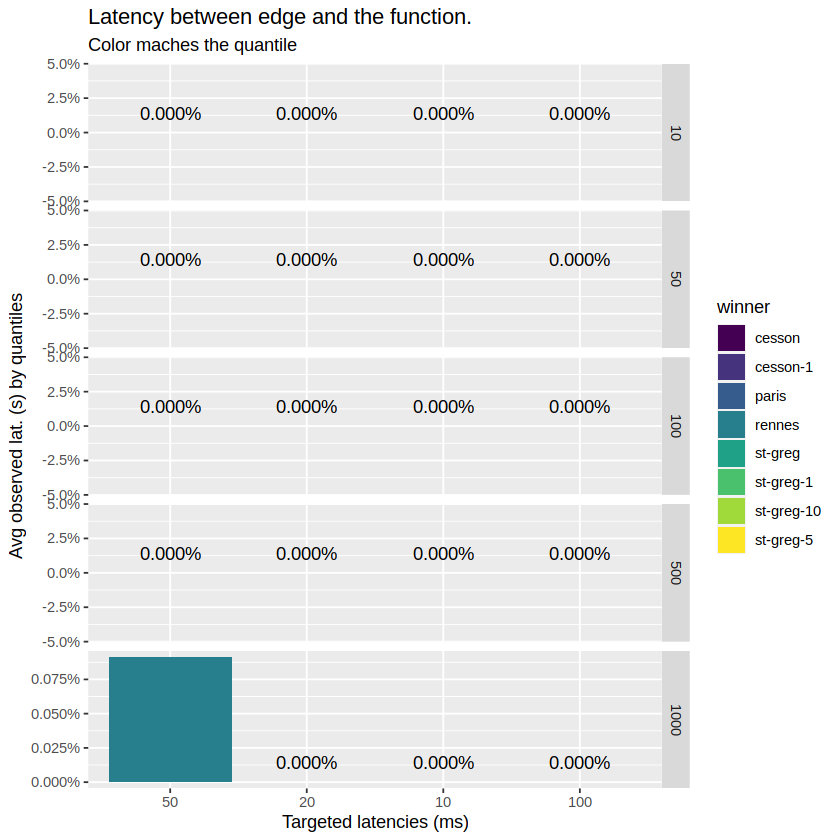

In [138]:
sla_breaks <- average %>%
    group_by(latency, period, winner) %>%
    select(latency, period, winner, break_sla) %>%
    group_by(latency, period) %>%
    add_count() %>%
    group_by(latency, period, winner, n) %>%
    summarize(broken = sum(break_sla, na.rm=TRUE), total = n()) %>%
    mutate(percent_per_winner = broken / n) %>%
    {.}

sla_breaks <- within(sla_breaks, 
                   latency <- factor(latency, 
                                      levels=names(sort(table(as.numeric(latency)), 
                                                        decreasing=TRUE))))

head(sla_breaks)

print(
  sla_breaks %>%
    group_by(latency) %>%
    arrange(desc(as.numeric(latency))) %>%
    ggplot(
      aes(
        x = latency,
        group = winner,
        y = percent_per_winner,
        fill = winner,
        # label = scales::percent(percent_per_winner)
      )
    ) +
    geom_col() +
    geom_text(aes(label = after_stat(scales::percent(y)), group = latency), 
        stat = 'summary', fun = sum, vjust = -1
      ) +
    scale_y_continuous(labels=scales::percent) +
    labs(
      x = "Targeted latencies (ms)",
      y = "Avg observed lat. (s) by quantiles",
      title = "Latency between edge and the function.",
      subtitle = paste("Color maches the quantile")
    ) +
    facet_grid(rows = vars(period), scales = "free") +
    scale_color_viridis(discrete = TRUE, option = "D") +
    scale_fill_viridis(discrete = TRUE)
)


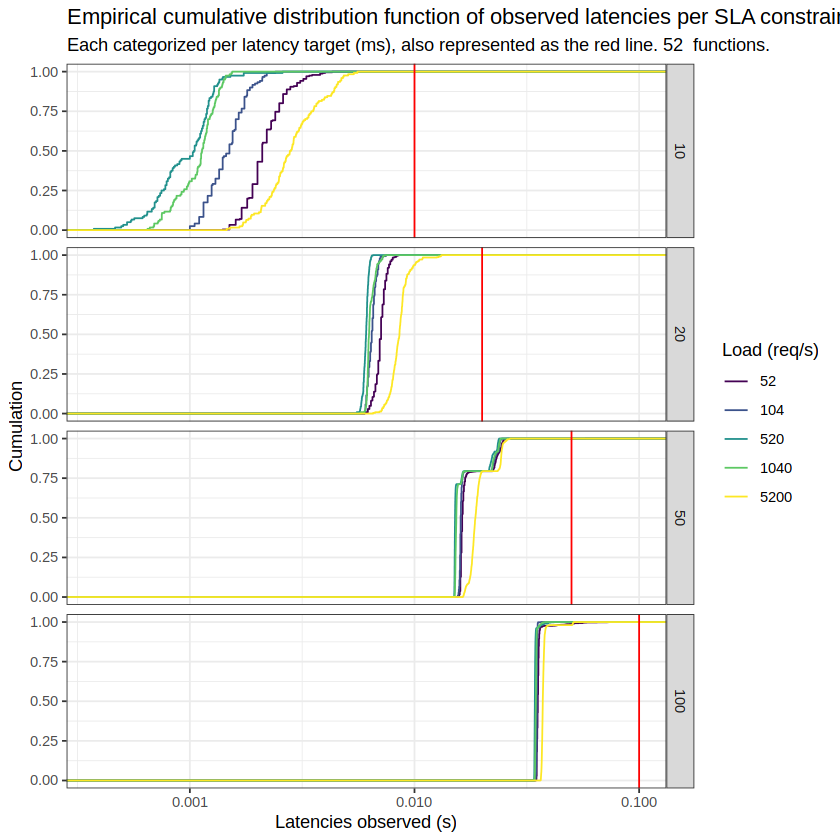

In [194]:
# dataLine <- average %>%
#   select(latency) %>%
#   summarize(mean_x = mean(Sepal.Length))
nb_functions <- average %>%
    group_by(tag) %>%
    select(tag) %>%
    distinct() %>%
    {.}

print(
  average %>%
    ggplot(
      aes(
        new_avg,
        # group = vars(period),
        color = factor(nrow(nb_functions) * 1000/as.numeric(period)),
        # y = new_avg
        # label = scales::percent(percent_per_winner)
      )
    ) +
    theme_bw() +
    stat_ecdf() +
    scale_x_continuous(trans="log10") +
    labs(
      x = "Latencies observed (s)",
      y = "Cumulation",
      title = "Empirical cumulative distribution function of observed latencies per SLA constraints",
      subtitle = paste("Each categorized per latency target (ms), also represented as the red line.", nrow(nb_functions), " functions."),
      color = "Load (req/s)"
    ) +
    facet_grid(rows = vars(factor(latency, stringr::str_sort(unique(latency), numeric = TRUE)))) +
    geom_vline(data=latencies, aes(xintercept=as.numeric(latency)/1000), colour="red") + 
    scale_color_viridis(discrete = TRUE, option = "D") +
    scale_fill_viridis(discrete = TRUE)
)
